In [5]:
import sys
 
sys.path.append('../')

In [9]:
import json
from tqdm import tqdm
from collections import defaultdict

import openai
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
from sklearn.linear_model import LinearRegression

from src.constants import API_KEYS
from src.hierarchy_tree import HierarchyTree
from src.utils import *

%load_ext autoreload
%autoreload 2

In [9]:
openai.api_key = API_KEYS["cybor"][0]

In [12]:

# Example dummy function hard coded to return the same weather
# In production, this could be your backend API or an external API
def get_current_weather(location, unit="fahrenheit"):
    """Get the current weather in a given location"""
    weather_info = {
        "location": location,
        "temperature": "72",
        "unit": unit,
        "forecast": ["sunny", "windy"],
    }
    return json.dumps(weather_info)


def run_conversation(messages, functions):
    # Step 1: send the conversation and available functions to GPT
    messages = messages
    functions = functions
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo-0613",
        messages=messages,
        functions=functions,
        function_call="auto",  # auto is default, but we'll be explicit
    )
    response_message = response["choices"][0]["message"]

    # Step 2: check if GPT wanted to call a function
    if response_message.get("function_call"):
        # Step 3: call the function
        # Note: the JSON response may not always be valid; be sure to handle errors
        available_functions = {
            "get_current_weather": get_current_weather,
        }  # only one function in this example, but you can have multiple
        function_name = response_message["function_call"]["name"]
        fuction_to_call = available_functions[function_name]
        function_args = json.loads(response_message["function_call"]["arguments"])
        function_response = fuction_to_call(
            location=function_args.get("location"),
            unit=function_args.get("unit"),
        )

        # Step 4: send the info on the function call and function response to GPT
        messages.append(response_message)  # extend conversation with assistant's reply
        messages.append(
            {
                "role": "function",
                "name": function_name,
                "content": function_response,
            }
        )  # extend conversation with function response
        second_response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo-0613",
            messages=messages,
        )  # get a new response from GPT where it can see the function response
        return response, second_response

TypeError: run_conversation() missing 2 required positional arguments: 'messages' and 'functions'

In [19]:
content = """Assume you are Joshua, an experienced data analyst. I will give you a detailed description of objects in an image and will ask you to complete a few tasks:

Description: "There is a 256 by 256 aerial image. One building is located at x = 67 and y = 8, in the top left of the image, with a size = 5775 pixels. One building is located at x = 114 and y = 59, in the center towards the top of the image, with a size = 3185 pixels. One building is located at x = 188 and y = 83, in the top right of the image, with a size = 2565 pixels. One building is located at x = 196 and y = 239, in the bottom right of the image, with a size = 2337 pixels. One building is located at x = 188 and y = 162, in the bottom right of the image, with a size = 6160 pixels. One building is located at x = 145 and y = 207, in the center towards the bottom of the image, with a size = 8374 pixels. One building is located at x = 153 and y = 41, in the center towards the top of the image, with a size = 3120 pixels. One building is located at x = 199 and y = 2, in the top right of the image, with a size = 7884 pixels. One building is located at x = 222 and y = 60, in the top right of the image, with a size = 2300 pixels. One small car is located at x = 30 and y = 34, in the top left of the image, with a size = 182 pixels. One small car is located at x = 38 and y = 50, in the top left of the image, with a size = 168 pixels. One small car is located at x = 56 and y = 70, in the top left of the image, with a size = 240 pixels. One small car is located at x = 86 and y = 83, in the top left of the image, with a size = 288 pixels."

Task 1: Determine spatial relations between objects. Task 2: Extract high-level spatial patterns between the objects, such as direction, clustering, dispersion, encirclement, interposition, etc. Task 3: Generate one or more independent image captions with high-level significant spatial patterns. Each starts with "CAP", with no longer than 32 tokens.
"""

In [29]:
content.replace("\n", " ")

'Assume you are Joshua, an experienced data analyst. I will give you a detailed description of objects in an image and will ask you to complete a few tasks:  Description: "There is a 256 by 256 aerial image. One building is located at x = 67 and y = 8, in the top left of the image, with a size = 5775 pixels. One building is located at x = 114 and y = 59, in the center towards the top of the image, with a size = 3185 pixels. One building is located at x = 188 and y = 83, in the top right of the image, with a size = 2565 pixels. One building is located at x = 196 and y = 239, in the bottom right of the image, with a size = 2337 pixels. One building is located at x = 188 and y = 162, in the bottom right of the image, with a size = 6160 pixels. One building is located at x = 145 and y = 207, in the center towards the bottom of the image, with a size = 8374 pixels. One building is located at x = 153 and y = 41, in the center towards the top of the image, with a size = 3120 pixels. One build

In [24]:
messages = [{
    "role": "user", 
    "content": "Question 1: Given two short sides of a right triangle are 5 and 10, calculate its hypotenuse. Question 2: Given two short sides of a right triangle are 6 and 7, calculate its hypotenuse"
}]

functions = [
        {
            "name": "get_hypotenuse",
            "description": "Get the hypotenuse of a right triangle given its other two sides",
            "parameters": {
                "type": "object",
                "properties": {
                    "a": {
                        "type": "string",
                        "description": "List of numbers. Each element represent the length of one short leg of a right triangle",
                    },
                    "b": {
                        "type": "string",
                        "description": "List of numbers. Each element represent the length of another short leg of a right triangle",
                    }
                },
                "required": ["a", "b"],
            },
        }
    ]


response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo-0613",
    messages=messages,
    functions=functions,
    function_call="auto",  # auto is default, but we'll be explicit
)
response_message = response["choices"][0]["message"]

In [25]:
response_message

<OpenAIObject at 0x1e183c85810> JSON: {
  "content": null,
  "function_call": {
    "arguments": "{\n  \"a\": \"5,6\",\n  \"b\": \"10,7\"\n}",
    "name": "get_hypotenuse"
  },
  "role": "assistant"
}

# DBSCAN

In [1]:
from sklearn.cluster import DBSCAN, OPTICS

In [2]:
train_labels_path = 'H:/xview/train_labels/xView_train.geojson'
annotations_path = "H:/xview/annotations"
train_images_path = "F:/train_images"
train_blocks_path = "F:/train_blocks"
type_csvs_path = "H:/xview/data.csv"
hierarchy_path = "H:/xview/src/hierarchy.json"

In [10]:
with open("../results/unique_blocks_info.json", "r") as f:
    unique_blocks_info = json.load(f)

In [11]:
from src.llm_functions_api import get_identify_clusters_function, get_identify_shape_function, get_identify_relationship_function

In [13]:
unique_blocks_info.keys()

dict_keys(['10.tif_31', '10.tif_33', '10.tif_34', '10.tif_45', '10.tif_47', '10.tif_48', '10.tif_61', '100.tif_42', '100.tif_56', '100.tif_70', '100.tif_84', '100.tif_98', '102.tif_1', '102.tif_2', '102.tif_4', '102.tif_5', '102.tif_8', '102.tif_12', '102.tif_14', '102.tif_15', '102.tif_18', '102.tif_21', '102.tif_22', '102.tif_24', '102.tif_26', '102.tif_35', '102.tif_38', '102.tif_41', '102.tif_45', '102.tif_48', '102.tif_49', '102.tif_54', '102.tif_55', '102.tif_56', '102.tif_73', '102.tif_83', '102.tif_86', '102.tif_87', '102.tif_97', '102.tif_104', '102.tif_106', '102.tif_111', '102.tif_114', '102.tif_118', '102.tif_122', '102.tif_129', '102.tif_136', '102.tif_138', '102.tif_166', '102.tif_190', '102.tif_191', '1036.tif_9', '1036.tif_10', '1036.tif_11', '1036.tif_24', '1036.tif_25', '1036.tif_31', '1036.tif_35', '1036.tif_39', '1036.tif_49', '1036.tif_50', '1036.tif_52', '1036.tif_53', '1036.tif_55', '1036.tif_97', '1036.tif_101', '1036.tif_126', '1037.tif_11', '1037.tif_14', '103

In [17]:
identify_cluster_func = get_identify_clusters_function(unique_blocks_info, "102.tif_73")

  0%|          | 0/12831 [00:00<?, ?it/s]

In [ ]:
identify_shape_func = 

In [18]:
identify_cluster_func()

group 0 contains a line of small car
group 1 contains some small car
group 0 is on the top left side of group 1


In [6]:
tree = HierarchyTree(hierarchy_path)

In [7]:
distance_freq = defaultdict(lambda: [])

for block_id in tqdm(unique_blocks_info):

    polygons = get_polygons(unique_blocks_info[block_id], image_size=256)
    X_coordinates = [poly['rectangle_coordinates'] for poly in polygons["polygons"]]
    types = [tree.find_significant_parent(poly['object']) for poly in polygons["polygons"]]
    
    types_indices = np.unique(types, return_inverse=True)[1]
    X = np.concatenate([X_coordinates, np.expand_dims(types_indices, axis=1)], axis=1)

    dist_matrix = csr_matrix(get_distance_matrix(X))

    weights_matrix = minimum_spanning_tree(dist_matrix).toarray()
    edges = np.stack(np.triu_indices(n=weights_matrix.shape[0], k=1)).T
    weights = weights_matrix[np.triu_indices(n=weights_matrix.shape[0], k=1)]
    edges_types = np.array(types)[edges]

    valid_edges_condition = edges_types[:, 0] == edges_types[:, 1] 
    valid_weights_condition = weights > 0

    valid_indices = np.where(valid_weights_condition & valid_edges_condition)[0]
    valid_edges = edges[valid_indices]
    valid_weights = weights[valid_indices]
    valid_edges_types = edges_types[valid_indices] 
    
    for i, (start, _) in enumerate(valid_edges_types):
        distance_freq[start].append(valid_weights[i])

100%|████████████████████████████████████████████████████████████████████████████| 12831/12831 [02:10<00:00, 98.28it/s]


In [8]:
distance_thres_elbow = {key: elbow_cut_off(item) for key, item in distance_freq.items()}
distance_thres_percentile = {key: np.percentile(item, 75) for key, item in distance_freq.items()}

  0%|                                                                                        | 0/12831 [00:00<?, ?it/s]

group 0 contains some building
group 1 contains some vehicle
group 2 contains some shipping container
group 1 is on the right side of group 2
group 1 is on the top right side of group 0


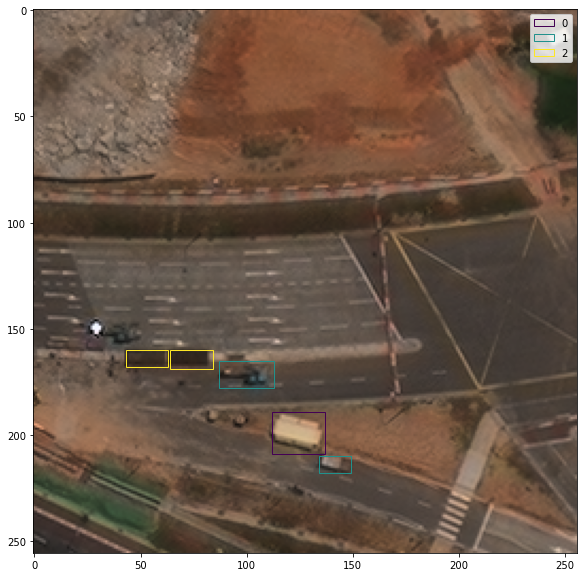

  0%|▎                                                                             | 61/12831 [00:00<01:24, 150.86it/s]

group 0 contains some dump truck
group 1 contains some truck
group 2 contains some building
group 3 contains some engineering vehicle
group 2 is on the left side of group 1
group 1 is on the right side of group 0
group 1 is on the top left side of group 3


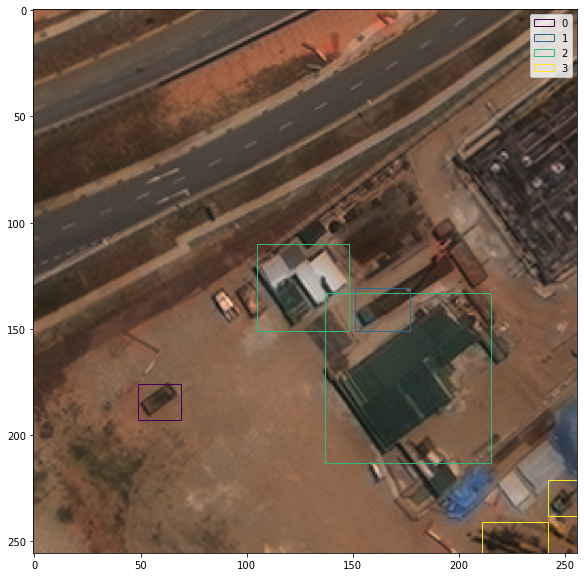

group 0 contains some damaged building
group 1 contains some excavator
group 2 contains some engineering vehicle
group 2 is on the bottom side of group 1
group 1 is on the top right side of group 0


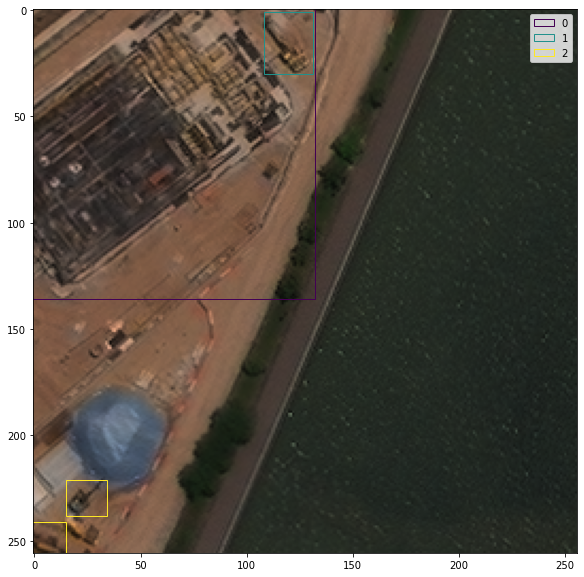

group 0 contains some building
group 1 contains some building
group 2 contains some truck
group 3 contains some vehicle
group 4 contains some truck
group 3 is on the left side of group 2
group 3 is on the bottom side of group 4
group 2 is on the top side of group 0
group 0 is on the right side of group 1


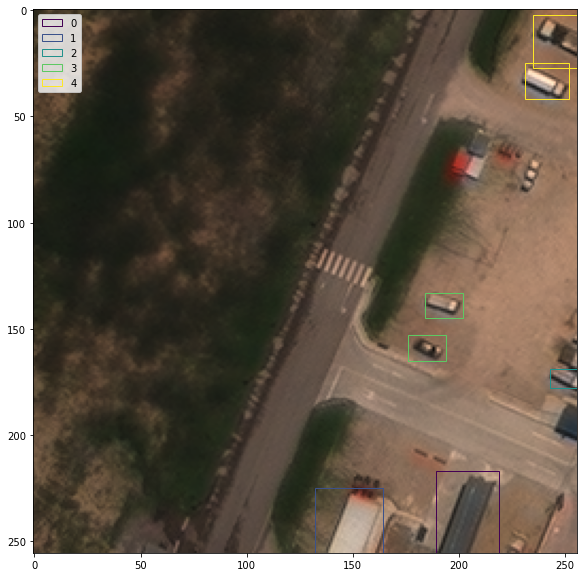

group 0 contains some truck with box
group 1 contains some utility truck
group 2 contains some vehicle
group 2 is on the top side of group 0
group 2 is on the right side of group 1


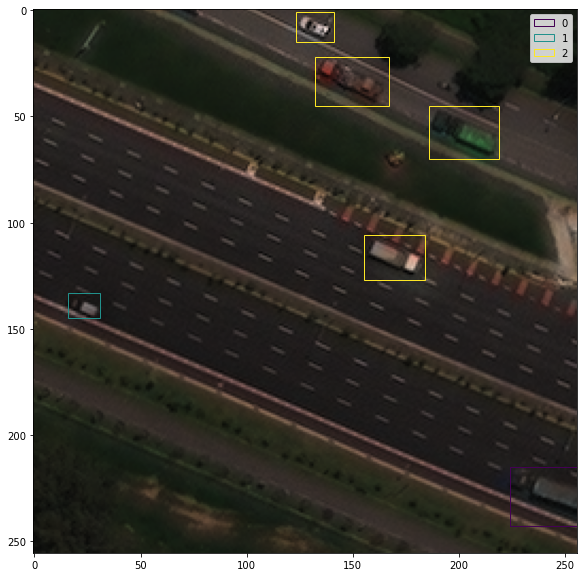

group 0 contains some building
group 1 contains a line of building
group 2 contains some building
group 1 is on the bottom side of group 0
group 0 is on the left side of group 2


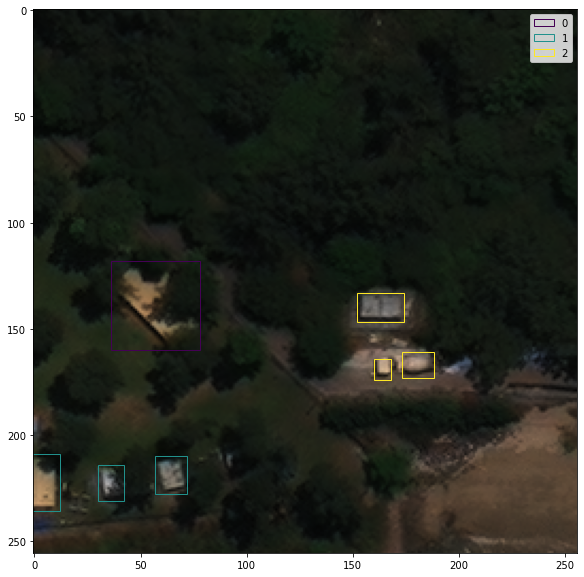

  1%|▍                                                                              | 66/12831 [00:02<32:24,  6.56it/s]

group 0 contains some building
group 1 contains some building
group 2 contains some maritime vessel
group 1 is on the left side of group 0
group 0 is on the bottom side of group 2


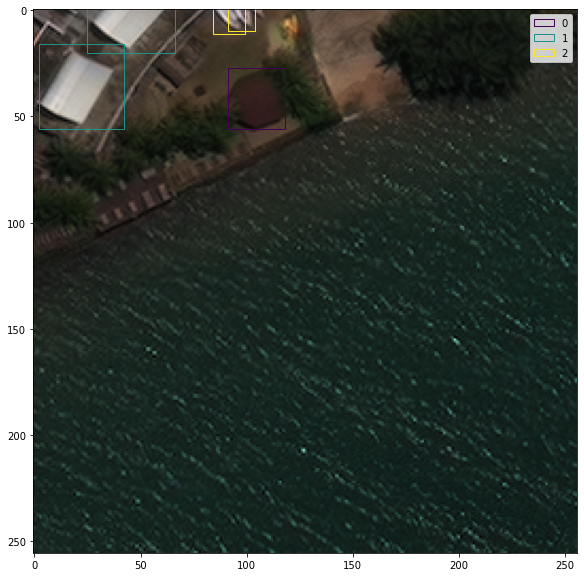

group 0 contains some building
group 1 contains some building
group 2 contains a line of storage tank
group 2 is on the top side of group 0
group 2 is on the right side of group 1


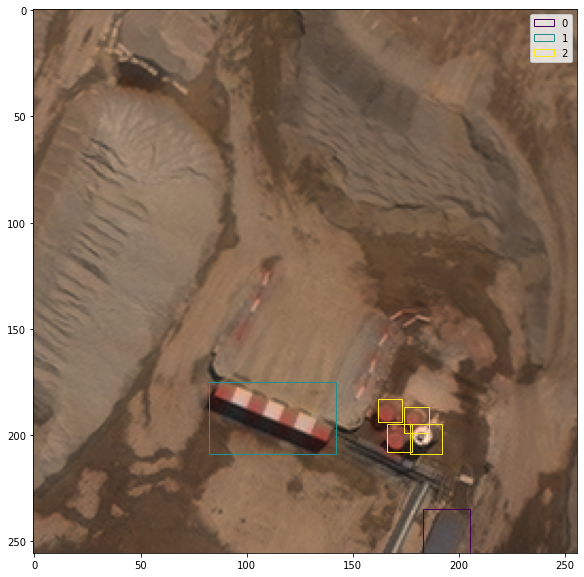

group 0 contains some engineering vehicle


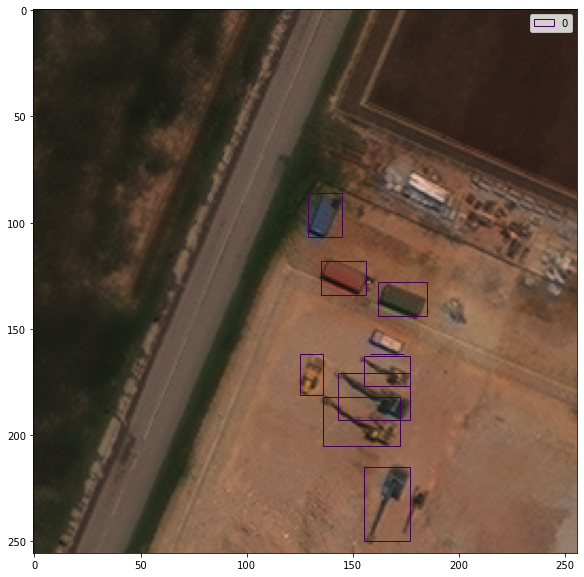

group 0 contains some building
group 1 contains some building
group 2 contains some building
group 3 contains some truck
group 3 is on the right side of group 0
group 0 is on the bottom left side of group 1
group 1 is on the bottom side of group 2


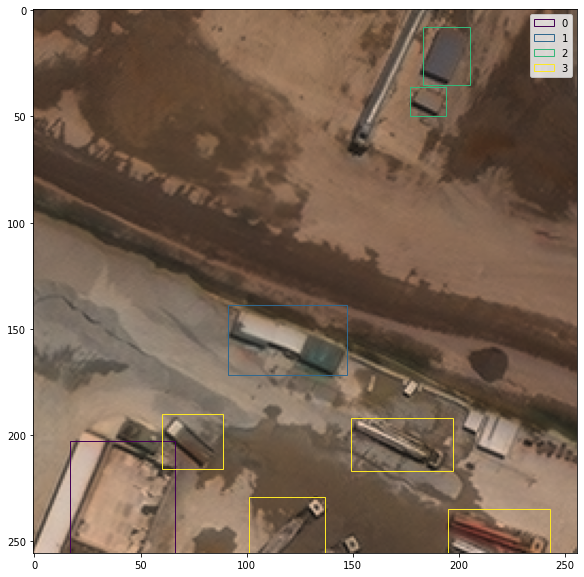

100%|██████████████████████████████████████████████████████████████████████████| 12831/12831 [00:04<00:00, 2572.09it/s]


In [102]:
count = 0
for block_id in tqdm(unique_blocks_info):
    if 60 <= count <= 69: 
        polygons = get_polygons(unique_blocks_info[block_id], image_size=256)
        polygons["polygons"] = [poly for poly in polygons["polygons"] if poly["object"] != "construction site"]
        X_coordinates = [poly['rectangle_coordinates'] for poly in polygons["polygons"]]
        original_types = [poly['object'] for poly in polygons["polygons"]]
        types = [tree.find_significant_parent(poly['object']) for poly in polygons["polygons"]]

        types_indices = np.unique(types, return_inverse=True)[1]
        X = np.concatenate([X_coordinates, np.expand_dims(types_indices, axis=1)], axis=1)

        dist_matrix = csr_matrix(get_distance_matrix(X))

        weights_matrix = minimum_spanning_tree(dist_matrix).toarray()
        edges = np.stack(np.triu_indices(n=weights_matrix.shape[0], k=1)).T
        weights = weights_matrix[np.triu_indices(n=weights_matrix.shape[0], k=1)]
        edges_types = np.array(types)[edges]
        upper_thres = np.array([distance_thres_percentile[t] for t in edges_types[:, 0]])

        valid_edges_condition = edges_types[:, 0] == edges_types[:, 1] 
        none_empty_weights_condition = weights > 0
        valid_weights_condition = weights < upper_thres
        
        valid_indices = np.where(valid_weights_condition & none_empty_weights_condition & valid_weights_condition)[0]
        valid_edges = edges[valid_indices]
        valid_weights = weights[valid_indices]
        valid_edges_types = edges_types[valid_indices] 
        
        clusters = get_clusters(X.shape[0], valid_edges)
        
        invalid_indices = np.where(none_empty_weights_condition & ~(valid_weights_condition & valid_edges_condition))[0]
        invalid_edges = edges[invalid_indices]
        connect_array = np.concatenate([clusters[invalid_edges], np.flip(clusters[invalid_edges], axis=1)])
        
        for i, cid in enumerate(np.unique(clusters)):
            c_types = [original_types[i] for i, t in enumerate(original_types) if clusters[i] == cid]
            objects_common_parents = tree.find_common_parent(np.unique(c_types))
            if detect_line_shape(X[clusters == cid], ae_thres=0.7):
                print(f"group {cid} contains a line of {objects_common_parents}")
            else:
                print(f"group {cid} contains some {objects_common_parents}")
        
        describe_relations(connect_array, X, clusters)
        
        random_test_sub_blocks(polygons, block_id, clusters, train_blocks_path)
        
    count += 1

In [87]:
clusters

array([0, 1, 2, 2, 3, 3, 3, 3], dtype=int64)

In [99]:
def describe_relations(connectivity, X, clusters):
    if connectivity.shape[0] == 0:
        return []
    
    cluster_ids, counts = np.unique(clusters, return_counts=True)

    queue = [cluster_ids[np.argmax(counts)]]
    visited_edges = set()
    relations = []

    while queue: 
        source = queue.pop(0)
        neighbours = connectivity[connectivity[:, 0] == source, 1].tolist()
        valid_neighbours = []
        
        for neigh in neighbours:
            current_edge = tuple(sorted([source, neigh]))
            if current_edge not in visited_edges:
                queue.append(neigh)
                valid_neighbours.append(neigh)
                visited_edges.add(current_edge)
        relations.append([source, valid_neighbours])
        
    for source, targets in relations:
        for target in targets:
            is_inside, is_outside, is_mixture, orientation = detect_orientation(X[clusters == source, :-1], X[clusters == target, :-1])
            if is_inside or is_mixture: 
                print(f"group {source} is between group {target}")
            elif is_outside:
                print(f"group {source} is on the {orientation} side of group {target}")
        
    return relations

0 1 (False, True, False, 'bottom left')
0 3 (False, True, False, 'left')
1 2 (False, True, False, 'bottom')
1 0 (False, True, False, 'top right')
3 0 (False, True, False, 'right')
2 1 (False, True, False, 'top')


In [37]:
clusters[invalid_edges]

array([[0, 1],
       [0, 3],
       [1, 2]], dtype=int64)

In [19]:
invalid_edges

array([[0, 1],
       [0, 4],
       [1, 3]])

In [229]:
X_a = X[clusters == 2, :-1]
X_b = X[clusters == 0, :-1]



def detect_orientation(X_a, X_b):
    n_a = X_a.shape[0]
    n_b = X_b.shape[0]

    vectors = np.tile(np.expand_dims(X_a, axis=1), (1, n_b, 1)) - np.tile(np.expand_dims(X_b, axis=0), (n_a, 1, 1))

    flatten_vectors = np.concatenate([vectors[:, :, :2], vectors[:, :, 2:]], axis=1)
    n_vectors = flatten_vectors.shape[1]

    vectors_a = np.tile(np.expand_dims(flatten_vectors, axis=2), (1, 1, n_vectors, 1))
    vectors_b = np.tile(np.expand_dims(flatten_vectors, axis=1), (1, n_vectors, 1, 1))
    unit_vectors_a, unit_vectors_b = unit_vector(vectors_a), unit_vector(vectors_b)

    products = np.sum(unit_vectors_a * unit_vectors_b, axis=-1)
    angles = np.arccos(np.clip(products, -1.0, 1.0)) / np.pi
    vectors_opposite = np.any(angles > (135 / 180), axis=-1)

    objects_inside = np.any(opposite_vectors, axis=-1)
    is_inside = np.all(objects_inside)
    is_outside = np.all(~objects_inside)
    is_mixture = (not is_inside) and (not is_outside)

    unit_flatten_vectors = unit_vector(flatten_vectors)
    orientation_objects = unit_vector(np.sum(unit_flatten_vectors, axis=-2))
    orientation = unit_vector(np.sum(orientation_objects, axis=-2))
    horizontal_string = ("right" if orientation[0] > 0 else "left") if np.abs(orientation[0]) > 0.6 else ""
    vertical_string = ("top" if orientation[1] > 0 else "bottom")  if np.abs(orientation[1]) > 0.6 else ""
    orientation_string = f"{vertical_string} {horizontal_string}".strip()
    return is_inside, is_outside, is_mixture, orientation_string


In [227]:
orientation_string

'right'

In [214]:
orientation

array([ 0.99435161, -0.1061361 ])

In [178]:
unit_vectors_a

array([[[[ 0.80768699,  0.5896115 ],
         [ 0.80768699,  0.5896115 ]],

        [[ 0.70710678, -0.70710678],
         [ 0.70710678, -0.70710678]]],


       [[[ 0.9788587 ,  0.20453764],
         [ 0.9788587 ,  0.20453764]],

        [[ 0.62469505, -0.78086881],
         [ 0.62469505, -0.78086881]]],


       [[[ 0.9723873 ,  0.23337295],
         [ 0.9723873 ,  0.23337295]],

        [[ 0.7592566 , -0.65079137],
         [ 0.7592566 , -0.65079137]]],


       [[[ 0.97193595,  0.23524564],
         [ 0.97193595,  0.23524564]],

        [[ 0.81373347, -0.58123819],
         [ 0.81373347, -0.58123819]]],


       [[[ 0.70240855,  0.711774  ],
         [ 0.70240855,  0.711774  ]],

        [[-0.70710678, -0.70710678],
         [-0.70710678, -0.70710678]]],


       [[[ 0.7450147 ,  0.66704805],
         [ 0.7450147 ,  0.66704805]],

        [[ 0.21693046, -0.97618706],
         [ 0.21693046, -0.97618706]]]])

In [164]:
angles

array([[[0.00000000e+00, 4.50719134e-01],
        [4.50719134e-01, 6.70787928e-09]],

       [[0.00000000e+00, 3.50792366e-01],
        [3.50792366e-01, 0.00000000e+00]],

       [[0.00000000e+00, 3.00539044e-01],
        [3.00539044e-01, 0.00000000e+00]],

       [[0.00000000e+00, 2.73021005e-01],
        [2.73021005e-01, 6.70787928e-09]],

       [[0.00000000e+00, 9.97892018e-01],
        [9.97892018e-01, 0.00000000e+00]],

       [[0.00000000e+00, 6.62837948e-01],
        [6.62837948e-01, 0.00000000e+00]]])

In [156]:
np.any((np.arccos(np.clip(products, -1.0, 1.0)) / np.pi) > (135 / 180), axis=(1, 2))

array([False, False, False, False,  True, False])

In [112]:
np.arccos(np.clip(unit_vectors_a * unit_vectors_b, -1.0, 1.0)) / 

(1, 12, 12, 2)

In [85]:
np.all(vectors_product > 0)

False

In [64]:
np.tile(np.expand_dims(vectors, axis=1), (1, 2, 1, 1))

array([[[[-205,   62, -234,   -4],
         [-106,   99, -133,   36]],

        [[-205,   62, -234,   -4],
         [-106,   99, -133,   36]]],


       [[[  -9,  146,  -22,   80],
         [  90,  183,   79,  120]],

        [[  -9,  146,  -22,   80],
         [  90,  183,   79,  120]]],


       [[[-131,  108, -162,  170],
         [ -32,  145,  -61,  210]],

        [[-131,  108, -162,  170],
         [ -32,  145,  -61,  210]]]], dtype=int64)

In [19]:
detect_line_shape(X[clusters == 0], ae_thres=0.9)

False

In [74]:
X

array([[ 57, 210,  72, 228,   0],
       [ 36, 118,  78, 160,   0],
       [ 30, 214,  42, 231,   0],
       [-10, 209,  12, 236,   0],
       [152, 133, 174, 147,   0],
       [160, 164, 168, 174,   0],
       [173, 161, 188, 173,   0]], dtype=int64)

In [75]:
clusters

array([1, 0, 1, 1, 2, 2, 2], dtype=int64)

In [79]:
X[clusters==1, :-1]

array([[ 57, 210,  72, 228],
       [ 30, 214,  42, 231],
       [-10, 209,  12, 236]], dtype=int64)

In [82]:
coords = X[clusters==1, :-1]

center_x = coords[:, [0, 2]].mean(axis=1, keepdims=True)
center_y = coords[:, [1, 3]].mean(axis=1, keepdims=True)
coords_combined = np.concatenate([coords, center_x, center_y], axis=1)

coords_x, coords_y = coords_combined[:, [0, 2, 4]], coords_combined[:, [1, 3, 5]]

coords_x_diff = coords_x[:-1] - coords_x[1:]
coords_y_diff = coords_y[:-1] - coords_y[1:]

tan = coords_y_diff / coords_x_diff
degrees = np.arctan(tan) / np.pi

In [83]:
coords_y_diff

array([[-4. , -3. , -3.5],
       [ 5. , -5. ,  0. ]])

In [84]:
tan

array([[-0.14814815, -0.1       , -0.12280702],
       [ 0.125     , -0.16666667,  0.        ]])

In [85]:
degrees

array([[-0.04681649, -0.03172552, -0.03889593],
       [ 0.03958342, -0.05256846,  0.        ]])

In [119]:
def root_mean_squared_error(prediction, reference):
    preds_array = np.array(prediction)
    refers_array = np.array(reference)
    
    return np.sqrt(np.square(preds_array - refers_array).sum()) / preds_array.shape[0]

In [122]:
X = X[clusters==1]


center_x = X[:, [0, 2]].mean(axis=1)
center_y = X[:, [1, 3]].mean(axis=1)
# X_combined = np.concatenate([X, center_x, center_y])
# center = np.concatenate([center_x, center_y], axis=1)

tl_x, tl_y = X[:, 0], X[:, 1]
br_x, br_y = X[:, 2], X[:, 3]

center_lr = LinearRegression()
tl_lr = LinearRegression()
br_lr = LinearRegression()

center_lr.fit(np.expand_dims(center_x, 1), center_y)
tl_lr.fit(np.expand_dims(tl_x, 1), tl_y)
br_lr.fit(np.expand_dims(br_x, 1), br_y)

center_y_hat = center_lr.predict(np.expand_dims(center_x, 1))
tl_y_hat = tl_lr.predict(np.expand_dims(tl_x, 1))
br_y_hat = br_lr.predict(np.expand_dims(br_x, 1))

center_lr_rmse = mean_squared_error(center_y_hat, center_y)
tl_lr_rmse = mean_squared_error(tl_y_hat, tl_y)
br_lr_rmse = mean_squared_error(br_y_hat, br_y)

center_lr_tan = center_lr.coef_[0]
tl_lr_tan = tl_lr.coef_[0]
br_lr_tan = br_lr.coef_[0]

all_rmse = [center_lr_rmse, tl_lr_rmse, br_lr_rmse]
all_degrees = np.arctan([center_lr_tan, tl_lr_tan, br_lr_tan]) / np.pi

valid_rmse = max(all_rmse) < 20
valid_angles = np.ptp(all_degrees) < 0.25

# return center_coef, corner_ul_coef, corner_br_coef

In [123]:
valid_rmse

True

In [125]:
all_degrees

array([-0.01687121,  0.00742184, -0.04219246])

In [115]:
mean_squared_error(tl_y_hat, tl_y)

4.254669013395911

In [116]:
mean_squared_error(br_y_hat, br_y)

0.22222222222222224

In [99]:
tl_fit.intercept_

210.40143737166323

In [47]:
center_fit.score(np.expand_dims(center_x, 1), center_y)

[0.11331406001887205, 0.2721856884802676, 0.03275739682481122]

In [30]:
LinearRegression().fit(np.expand_dims(center_x, 1), center_y).coef_[0]

-0.34177952659139893

In [ ]:
sm.OLS(np.expand_dims(center_x, 1), center_y).fit().summary()

In [129]:
np.arctan(fit_degrees) / np.pi

array([-0.10482988, -0.07936469, -0.12715586])

In [127]:
fit_degrees

[-0.34177952659139893, -0.2546299893801643, -0.4221708875199635]

In [121]:
fit_coefs

(-0.6509309786342289, -0.4830401130359666, -0.7946207684782454)

In [78]:
X_input[:, :2]

array([[112, 189],
       [ 87, 165],
       [ 43, 160],
       [ 64, 160],
       [134, 210]], dtype=int64)

array([[1.        , 0.92976518],
       [0.92976518, 1.        ]])

In [82]:
np.corrcoef(X_input[:, 2], X_input[:, 3])

array([[1.       , 0.9342089],
       [0.9342089, 1.       ]])

1675.tif_14


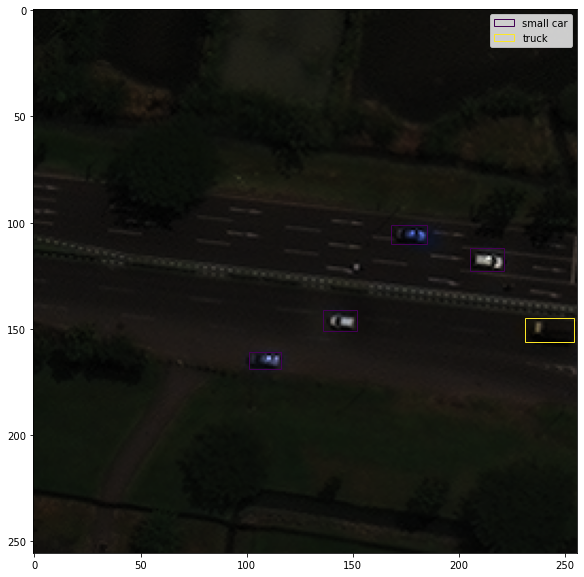

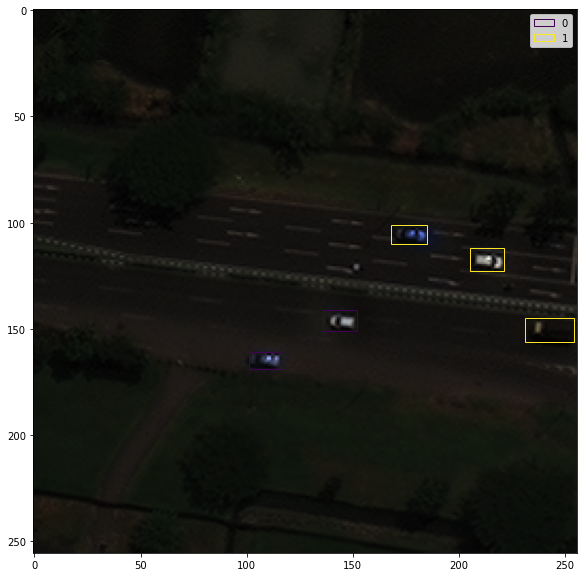

'1675.tif_14'

In [22]:
block_id = random.sample(unique_blocks_info.keys(), 1)[0]

polygons = get_polygons(unique_blocks_info[block_id], image_size=256)
X_coordinates = [poly['rectangle_coordinates'] for poly in polygons["polygons"]]
types = [poly['object'] for poly in polygons["polygons"]]
types_indices = np.unique(types, return_inverse=True)[1]
X = np.concatenate([X_coordinates, np.expand_dims(types_indices, axis=1)], axis=1)



clustering = DBSCAN(eps = 150, min_samples=1, metric=box_distance_with_type).fit(X)

print(block_id)
random_test_sub_blocks(polygons, block_id, types, train_blocks_path)
random_test_sub_blocks(polygons, block_id, clustering.labels_, train_blocks_path)

In [7]:
X

array([[-15,  22,  44,  74,   0],
       [162,  29, 212,  77,   0],
       [ 44, -34, 177,  54,   0],
       [228,  44, 249,  65,   1],
       [151,  89, 163,  99,   2],
       [140,  99, 151, 109,   2],
       [218,  25, 232,  40,   2],
       [135, 124, 148, 138,   2],
       [207,  11, 226,  28,   2],
       [140, 117, 168, 153,   3]], dtype=int64)

In [10]:
box_distance(X[0], X[1])

118.0

In [58]:
clustering.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=int64)